In [1]:
import csv
import cv2

import numpy as np

import matplotlib.image as mpimg 

% matplotlib inline

### Define Generator and Pipeline to process images in folder

In [2]:
# implementing generators
def generator(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3)) #depending on image input
    batch_labels = np.zeros((batch_size,1))
    
    num_samples = (features.shape[0]//batch_size) * batch_size
    
    while True:
        for i in range(0,num_samples, batch_size):
            batch_start = i
            batch_end = i + batch_size
            batch_samples = features[batch_start:batch_end]
            batch_samples_labels = labels[batch_start:batch_end]
        for j,line in enumerate(batch_samples):
            temp = augment_brightness_camera_images(mpimg.imread(batch_samples[j])[55:137,:,:]) #to crop here use [55:137,:,:]
            temp = cv2.resize(temp, (64,64))
            batch_features[j] = temp
            batch_labels[j] = batch_samples_labels[j]
        yield batch_features, batch_labels

def process_path(list_paths):
    images_path = []
    measurements = []
    
    for each_dataset_path in list_paths:
        lines = []
        with open(each_dataset_path+"driving_log.csv") as f:
            reader = csv.reader(f)
            # next(reader, None) # if contains header
            for line in reader:
                lines.append(line)
        for line in lines:
            for index in range(3):
                path = each_dataset_path+"IMG/"+line[index].split('\\')[-1] #filepath flag
                images_path.append(path)
                correction = 0
                if index==1:        #left
                    correction+=0.25
                elif index==2:      #right
                    correction-=0.25
                measurements.append(float(line[3])+correction)
    
    return np.array(images_path), np.array(measurements)


def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def resize_to_target_size(image):
    return cv2.resize(image, (64,64))

#### Extract image paths for generator

In [12]:
list_paths = ["/home/carnd/CarND-Behavioral-Cloning-P3/simulator data1/",
             "/home/carnd/CarND-Behavioral-Cloning-P3/simulator data2/"]
              #"/home/carnd/CarND-Behavioral-Cloning-P3/lastnew1/"]

X_train_p,y_train_p = process_path(list_paths)


from sklearn.utils import shuffle
X_train_p, y_train_p = shuffle(X_train_p, y_train_p)

from sklearn.model_selection import train_test_split
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_train_p, y_train_p, test_size=0.1)

In [13]:
# small check
print('training : ',X_train_p.shape,'validation : ',y_valid_p.shape)

training :  (46242,) validation :  (5139,)


### Model Architecture

In [5]:
# Architecture

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras import regularizers

Using TensorFlow backend.


In [14]:
model = Sequential()
model.add(Lambda(lambda x:x/255-0.5, input_shape=(64, 64, 3)))
#model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(3, 1, 1))

model.add(Convolution2D(32, 3, 3, activation='elu'))
model.add(Convolution2D(32, 3, 3, activation='elu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, activation='elu'))
model.add(Convolution2D(128, 3, 3, activation='elu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dense(16))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 64, 64, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 64, 64, 3)     12          lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 62, 62, 32)    896         convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 60, 60, 32)    9248        convolution2d_9[0][0]            
___________________________________________________________________________________________

In [15]:
# using generator
batchsize = 256

model.compile(loss='mse', optimizer = 'adam')
history = model.fit_generator(generator(X_train_p, y_train_p, batchsize), samples_per_epoch=10240*5, nb_epoch=2, 
                    verbose=1, validation_data = generator(X_valid_p,y_valid_p,batchsize), nb_val_samples=2048*5)

Epoch 1/2
51200/51200 [==============================] - 198s - loss: 0.1338 - val_loss: 0.0432
Epoch 2/2
51200/51200 [==============================] - 190s - loss: 0.0278 - val_loss: 0.0366


In [16]:
# Save model
model.save('model64_3.h5')

### Visualize MSE

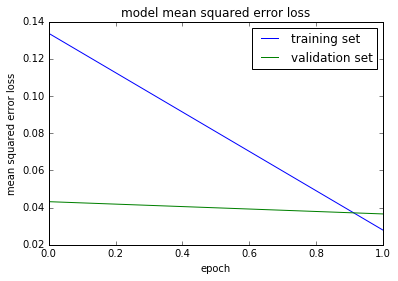

In [17]:
# plot the training and validation loss for each epoch

from keras.models import Model
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Visualize Data after augmentation

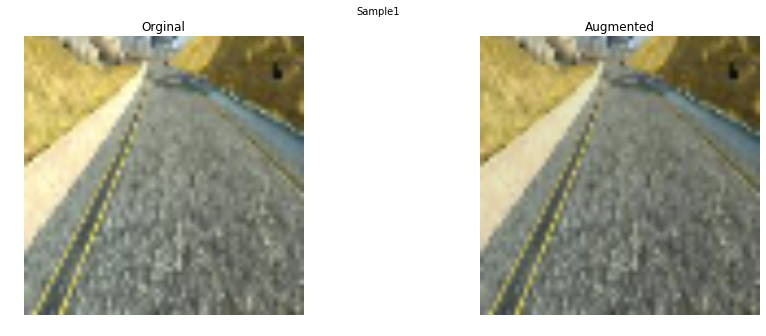

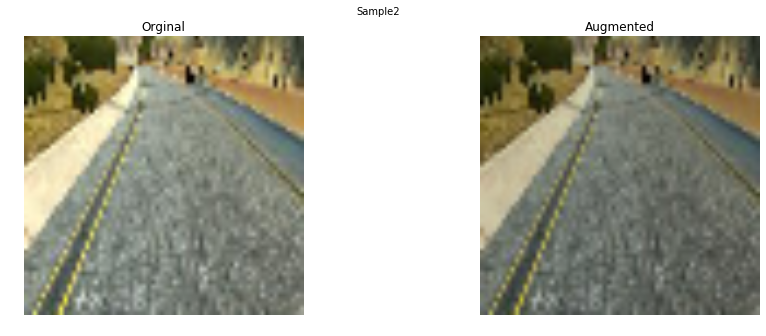

In [11]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


for i in range(2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Orginal')
    plt.imshow(cv2.resize(mpimg.imread(X_train_p[i*100//7])[55:137,:,:],(64,64))) #100//7 just for random integer
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Augmented')
    plt.imshow(cv2.resize(augment_brightness_camera_images(mpimg.imread(X_train_p[i*100//7])[55:137,:,:]),(64,64)))
    plt.suptitle('Sample'+str(i+1))
    plt.show()
    
